In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pdb

**SMART goal**: Applying the coupled autoencoder to data from Tolias lab.

 - Sequencing data obtained from: [GSE134378](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE134378). 
 - Link contains raw reads, a table of read counts, table of RPKM values
 - Link to paper (https://www.nature.com/articles/s41467-019-12058-z)

In [2]:
D = pd.read_csv('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/L4-Tolias-lab/GSE134378_L4_counts.txt',delimiter='\t')
D = D.transpose()
D.reset_index(inplace=True)
D.columns = D.iloc[0]
D.drop(D.index[0],inplace=True)
D.reset_index(drop=True,inplace=True)
D.rename(columns={'gene':'sample_id'},inplace=True)
D

,sample_id,Adora1,Sntg1,Prim2,Bai3,Cflar,Gpr39,Obsl1,Syt14,Pld5,...,Gm16367,Vmn1r62,Vmn1r186,Vmn1r63,Vmn1r187,Tmlhe,Vamp7,Spry3,Zf12,eGFP
0,20180604_sample_1_L4_S97,0,296,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20180604_sample_2_L4_S98,82,51,0,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20180604_sample_3_L4_S99,0,42,0,75,38,0,0,18,0,...,0,0,0,0,0,0,0,0,0,0
3,20180605_sample_1_L4_S100,87,136,0,237,31,0,70,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20180605_sample_2_L4_S101,167,736,0,311,0,0,82,60,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,20180921_sample_8_L4_S154,0,533,0,6,0,0,4,146,0,...,0,0,0,0,0,0,0,0,0,0
114,20180920_sample_9_L4_S155,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115,20180920_sample_10_L4_S157,87,343,0,187,0,0,25,0,0,...,0,0,0,0,0,0,0,0,0,0
116,20180920_sample_11_L4_S159,0,149,43,4,0,0,36,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Convert raw counts to log1p[cpm]
genes = D.columns.values[1:]
counts = D.iloc[0:,1:].values.astype(float)

#Convert to log1p(cpm)
cpm = np.empty_like(counts)
for i in range(cpm.shape[0]):
    cpm[i,:] = counts[i,:]*1e6/np.sum(counts[i,:])
logcpm = np.log1p(cpm)
del counts

In [4]:
print(logcpm.shape)
print(genes.shape)

(118, 24490)
(24490,)


In [5]:
#Select list of genes used for patchseq paper
O = sio.loadmat('/home/rohan/Dropbox/AllenInstitute/CellTypes'
                '/dat/raw/patchseq-v4/PS_v4_beta_0-4_all.mat',squeeze_me=True)

In [6]:
ind = np.flatnonzero(np.isin(genes,O['gene_id']))
print('{} out of {} genes present in Tolias dataset'.format(np.size(ind),np.size(O['gene_id'])))

1196 out of 1252 genes present in Tolias dataset


In [7]:
X = np.empty((logcpm.shape[0],len(O['gene_id'])))
X.fill(0)
for i,g in enumerate(O['gene_id']):
    k = np.flatnonzero(genes==g)
    if k.size==1:
        X[:,i]=np.squeeze(logcpm[:,k])
    elif k.size==0:
        print('Not measured ',g)
    elif k.size>1:
        print('Ignoring ',str(k.size),'duplicate entries =======>  ',g)

Not measured  LOC102632463
Not measured  LOC102634132
Not measured  LOC105243425
Not measured  LOC105246064
Not measured  LOC102634502
Not measured  LOC102633357
Not measured  Teddm3
Not measured  LOC101056001
Not measured  Shisa8
Not measured  LOC105246694
Not measured  LOC105242740
Not measured  G630016G05Rik
Not measured  Sptbn5
Not measured  Lppr1
Not measured  Kcnmb4os2
Not measured  LOC105243542
Not measured  1700019L22Rik
Not measured  Tcrb
Not measured  E530001K10Rik
Not measured  Drd1
Not measured  LOC105244376
Not measured  LOC105245487
Not measured  9630002D21Rik
Not measured  Lppr3
Not measured  2310075C17Rik
Ignoring  3 duplicate entries =======>   Snrpn
Not measured  LOC102636041
Not measured  Gad1-ps
Not measured  LOC105246832
Not measured  LOC102638670
Not measured  LOC105245190
Not measured  LOC102640573
Not measured  LOC102633724
Not measured  6530403H02Rik
Not measured  5330416C01Rik
Not measured  LOC102635502
Not measured  LOC105242710
Not measured  LOC105245838
Not

In [8]:
X.shape

(118, 1252)

In [9]:
#Save dataset
Data = {'gene_id':O['gene_id'],'log1p':X,'sample_id':D['sample_id'].values}
sio.savemat('/home/rohan/Dropbox/AllenInstitute/CellTypes/'
            'dat/raw/L4-Tolias-lab/Dataset.mat',
            Data,do_compression=True)

**Inference using a trained model**

In [10]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [12]:
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pdb
import sys
sys.path.append("/home/rohan/Dropbox/AllenInstitute/CellTypes/code/Patchseq-AE-Bioarxiv/")

Data = sio.loadmat('/home/rohan/Dropbox/AllenInstitute/CellTypes/'
            'dat/raw/L4-Tolias-lab/Dataset.mat',squeeze_me=True)

In [13]:
from ae_model_def import *
import tensorflow as tf
from data_funcs import *

#Instance of the model class
model_TE = Model_TE(T_output_dim=1252,
                    E_output_dim=45,
                    T_intermediate_dim=50,
                    E_intermediate_dim=40,
                    T_dropout=0.5,
                    E_gnoise_sd=0.05,
                    E_dropout=0.1,
                    latent_dim=3,
                    name='TE')

#Implicit model build
zT, zE, XrT, XrE = model_TE((tf.constant(np.random.rand(1,1252),dtype=tf.float32), tf.constant(np.random.rand(1,45),dtype=tf.float32)), training=False)

#Load weights
model_TE.load_weights('/home/rohan/Remote-AI/dat/result/TE_Patchseq_Bioarxiv/'
                      'v1_aT_1-0_aE_1-0_aM_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_cv_0_ri_0-weights.h5',by_name=True)

In [14]:
zTolias = model_TE.encoder_T(tf.constant(Data['log1p'],dtype=tf.float32),training=False)
zTolias=zTolias.numpy()

In [15]:
O = sio.loadmat('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/PS_v4_beta_0-4_all.mat',squeeze_me=True)
zAllen = model_TE.encoder_T(tf.constant(O['T_dat'],dtype=tf.float32),training=False)
zAllen=zAllen.numpy()

In [16]:
%matplotlib inline

(-3, 3)

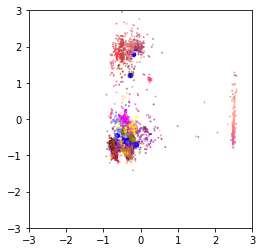

In [17]:
plt.figure(figsize=(4,4))
plt.scatter(zTolias[:,1],zTolias[:,2],c='b',s=20)
plt.scatter(zAllen[:,1],zAllen[:,2],c=O['cluster_color'],s=1,alpha=0.5)
ax=plt.gca()
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)

In [18]:
xlims=(-3,3)
ylims=(-3,3)
zlims=(-3,3)
padval=-210
fontsizeval=10

In [20]:
import os
import fnmatch
import pprint

import numpy as np
import scipy.io as sio
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import HTML

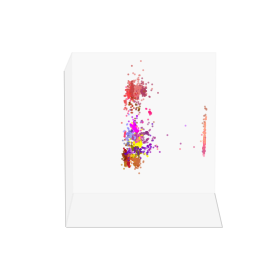

In [27]:
sns.set_style("whitegrid")
plt.ion()
fig = plt.figure(figsize=(4,4))    
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(zAllen[:,0], zAllen[:,1], zAllen[:,2],s=1,alpha=0.5,c=O['cluster_color'])
#sc2 = ax.scatter(zTolias[:,0], zTolias[:,1], zTolias[:,2],s=10,alpha=1,c='r')


ax.set_xticks([])
ax.set_zticks([])
ax.set_yticks([])

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')

ax.set_xlim(xlims[0],xlims[1])
ax.set_ylim(ylims[0],ylims[1])
ax.set_zlim(zlims[0],zlims[1])

plt.axis('on')
ax.set_frame_on(False)
plt.tight_layout()

ax.set_title(r'',pad=padval,fontsize=fontsizeval)
fig = plt.gcf()

def update(i):
    ax.view_init(elev=10., azim=i)
    fig.canvas.draw()
    fig.canvas.flush_events()
    return

anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
#HTML(anim.to_html5_video())

In [28]:
anim.save('/Users/fruity/Desktop/SMARTgoalref.gif', dpi=160, writer='imagemagick')

**Join ephys feature dataset**

In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np

In [2]:
data_path = "/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/L4-Tolias-lab/"
anno = pd.read_csv(data_path+"anno_L4_Tolias.csv")
anno = anno[['sample_id','cluster','confidence']]
ephys = pd.read_csv(data_path+"patch-seq-ephys-features_RG.csv")

In [3]:
#Merge ephys and transcriptomic annotations (intersection)
new_sample_id = []
for s in anno['sample_id'].values:
    a = s.split(sep='_',maxsplit=3)
    new_lbl = a[0]+'_'+a[1]+'_'+a[2]
    new_sample_id.append(new_lbl)
anno['T_sample_id'] = anno['sample_id']
anno['sample_id'] = np.array(new_sample_id,dtype = object)
anno = anno[anno['sample_id'].isin(ephys['sample_id'])].reset_index(drop=True)

In [4]:
X = anno.merge(ephys,on='sample_id')
X = X.rename(columns={'name sample':'E_sample_id'})
#print(X.columns.tolist())
X = X[['sample_id','T_sample_id','E_sample_id','cluster', 'confidence', 
       'ADP (mV)', 'AHP (mV)', 'AI', 'AP amplitude (mV)', 'AP threshold (mV)',
       'AP width (ms)', 'Max number of spikes', 'Input R (MOhm)', 'Vm (mV)',
       'Latency (ms)', 'Rheobase (pA)', 'Sag ratio', 'Tau (ms)', 'Cell type']]
X.to_csv(data_path+'anno_RG.csv') 

In [5]:
#Load Tolias transcriptomic dataset
D = sio.loadmat('/home/rohan/Dropbox/AllenInstitute/CellTypes/'
                'dat/raw/L4-Tolias-lab/Dataset.mat',squeeze_me=True)

In [6]:
base_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
ref_path = base_path + 'type_color_reference_Tasic18.csv' #Generated for inhibitory types from the FACS annotations
#Load reference colors
ref = pd.read_csv(ref_path)

In [7]:
ref.loc[ref['celltype']=='Sst Crh 4930553C11Rik ']

,Unnamed: 0,celltype,cluster_color
122,122,Sst Crh 4930553C11Rik,#C77767


In [8]:
#Cell types labels that are not in Tasic reference:
for i in np.unique(X.cluster.values[np.isin(X.cluster.values,ref['celltype'].values)==False]):
    print(i)

Sst Crh 4930553C11Rik


In [9]:
#Tolias cell types are colored black.
ref_tol=pd.DataFrame({'celltype':['Sst Crh 4930553C11Rik'],
              'cluster_color':['#C77767']})

#Spot checks
ref_tol = pd.concat([ref,ref_tol]).reset_index(drop=True)
ref_tol = ref_tol[['celltype','cluster_color']]

In [10]:
X.cluster.values

array(['Sst Tac1 Htr1d', 'Sst Calb2 Pdlim5', 'Sst Hpse Cbln4',
       'Sst Calb2 Pdlim5', 'Sst Tac1 Tacr3', 'Sst Hpse Cbln4',
       'Sst Calb2 Pdlim5', 'Sst Calb2 Pdlim5', 'Sst Calb2 Pdlim5',
       'Sst Calb2 Pdlim5', 'Sst Calb2 Necab1', 'Sst Mme Fam114a1',
       'Sst Hpse Cbln4', 'Pvalb Reln Itm2a', 'Sst Calb2 Pdlim5',
       'Sst Mme Fam114a1', 'Sst Hpse Cbln4', 'Sst Crh 4930553C11Rik',
       'Sst Hpse Cbln4', 'Sst Tac2 Myh4', 'Sst Rxfp1 Prdm8',
       'Sst Rxfp1 Prdm8', 'Sst Hpse Cbln4', 'Pvalb Reln Itm2a',
       'Sst Hpse Cbln4', 'Sst Rxfp1 Prdm8', 'Sst Calb2 Pdlim5',
       'Sst Hpse Sema3c', 'Sst Calb2 Pdlim5', 'Sst Calb2 Pdlim5',
       'Sst Rxfp1 Eya1', 'Sst Hpse Cbln4', 'Sst Calb2 Pdlim5',
       'Sst Hpse Sema3c', 'Sst Hpse Cbln4', 'Sst Crh 4930553C11Rik',
       'Sst Hpse Cbln4', 'Pvalb Reln Itm2a', 'Sst Crhr2 Efemp1',
       'Sst Rxfp1 Prdm8', 'Sst Hpse Cbln4', 'Sst Hpse Cbln4',
       'Sst Tac2 Tacstd2', 'Sst Hpse Cbln4', 'Sst Crh 4930553C11Rik',
       'Sst Hpse Cbln

```
AP threshold
AP amplitude
AP width
afterhyperpolarization (AHP)
afterdepolarization (ADP)
first AP latency (Supplementary Fig. 4c, using the very first AP fired by the neuron. 

AP width was computed at the half AP height.
Adaptation index (AI) is defined as the ratio of the second interspike interval to the first (Supplementary Fig. 4b). 
We took the median over the five lowest depolarizing currents that elicited at least three spikes (if fewer than five were available, we used all of them).
```

 - ADP (mV)
 - AHP (mV)
 - AI
 - AP amplitude (mV)
 - AP threshold (mV)
 - AP width (ms)
 - Max number of spikes
 - Input R (MOhm)
 - Vm (mV)
 - Latency (ms)
 - Rheobase (pA)
 - Sag ratio
 - Tau (ms)

In [11]:
df_Data = pd.DataFrame({'T_sample_id' : D['sample_id']})
anno_Tolias = pd.merge(df_Data, X,left_on='T_sample_id',right_on='T_sample_id',how='left')
anno_Tolias = pd.merge(anno_Tolias, ref_tol,left_on='cluster',right_on='celltype',how='left')

In [12]:
anno_Tolias.shape

(118, 21)

In [13]:
from IPython.display import display, HTML
HTML(anno_Tolias.to_html())

,T_sample_id,sample_id,E_sample_id,cluster,confidence,ADP (mV),AHP (mV),AI,AP amplitude (mV),AP threshold (mV),AP width (ms),Max number of spikes,Input R (MOhm),Vm (mV),Latency (ms),Rheobase (pA),Sag ratio,Tau (ms),Cell type,celltype,cluster_color
0,20180604_sample_1_L4_S97,20180604_sample_1,20180604sample1,Sst Tac1 Htr1d,91.0,3.518790,-3.731895,729.434666,72.248112,-42.328943,1.36,3.0,405.425397,-55.866590,40.76,2.000000e+01,1.100842,18.953001,V1layer4,Sst Tac1 Htr1d,#804811
1,20180604_sample_2_L4_S98,20180604_sample_2,20180604sample2,Sst Calb2 Pdlim5,100.0,2.792712,-12.563817,108.482235,83.817627,-34.790721,0.88,21.0,296.437238,-57.365980,109.56,2.227273e+01,1.084718,20.212823,V1layer4,Sst Calb2 Pdlim5,#CC6D3D
2,20180604_sample_3_L4_S99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20180605_sample_1_L4_S100,20180605_sample_1,20180605sample1,Sst Hpse Cbln4,100.0,0.000000,-14.027730,118.738462,69.490960,-42.290803,0.76,22.0,164.916930,-67.211329,80.56,7.250000e+01,1.191198,14.114814,V1layer4,Sst Hpse Cbln4,#806B19
4,20180605_sample_2_L4_S101,20180605_sample_2,20180605sample2,Sst Calb2 Pdlim5,91.0,3.911160,-12.878809,124.642909,82.684878,-36.013559,0.88,24.0,267.502811,-58.161111,100.08,2.000000e+01,1.145632,21.853214,V1layer4,Sst Calb2 Pdlim5,#CC6D3D
5,20180605_sample_3_L4_S102,20180605_sample_3,20180605sample3,Sst Tac1 Tacr3,36.0,0.000000,-14.947891,117.417197,72.869662,-31.845935,0.80,25.0,303.672809,-47.200464,23.44,2.000000e+01,1.060308,16.867886,V1layer4,Sst Tac1 Tacr3,#B06411
6,20180605_sample_4_L4_S103,20180605_sample_4,20180605sample4,Sst Hpse Cbln4,100.0,2.664801,-10.244865,119.833208,78.613602,-45.700327,0.80,32.0,219.677973,-60.185108,47.24,2.341463e+01,1.092050,14.270535,V1layer4,Sst Hpse Cbln4,#806B19
7,20180605_sample_5_L4_S104,20180605_sample_5,20180605sample5,Sst Calb2 Pdlim5,100.0,0.000000,-14.140319,111.565386,88.395622,-33.523042,0.88,20.0,313.768918,-57.844933,68.88,2.000000e+01,1.199166,23.963160,V1layer4,Sst Calb2 Pdlim5,#CC6D3D
8,20180605_sample_12_L4_S109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,20180605_sample_6_L4_S105,20180605_sample_6,20180605sample6,Sst Calb2 Pdlim5,100.0,1.469024,-14.761809,109.856984,77.797454,-34.972124,0.80,31.0,308.073445,-47.189238,28.48,0.000000e+00,1.232716,21.756126,V1layer4,Sst Calb2 Pdlim5,#CC6D3D


 - Load augmented-decoder model
 - Validate representation
 - Train QDA classifier
 - Obtain Tolias data labels
 - Calculate accuracy/ contingency matrix for inhibitory cells
 - Predict ephys data
 - Scatter plot predictions vs measured tau, input resistance, threshold?, amplitude? for the ~112 cells. 

In [172]:
from ae_model_def import *
import tensorflow as tf
from data_funcs import *
import json
import scipy.io as sio

E_names_file = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/E_names.json'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)
O['E_names']=np.concatenate([O['pc_name'],O['feature_name']],axis = 0)
with open(E_names_file) as f:
    temp = json.load(f)
O['E_names'] = np.array([temp[i] for i in O['E_names']])

XT_orig = O['T_dat']
XE_orig = np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)


#Instance of the model class
model_TE = Model_TE_aug_decoders(T_output_dim=1252,
                    E_output_dim=68,
                    T_intermediate_dim=50,
                    E_intermediate_dim=40,
                    T_dropout=0.5,
                    E_gauss_noise_wt=0.0,
                    E_gnoise_sd=0.0,
                    E_dropout=0.0,
                    alpha_T = 1.0,
                    alpha_E = 1.0,
                    lambda_TE = 1.0,
                    latent_dim=3,
                    name='TE')

#Implicit model build
zT, zE, XrT, XrE = model_TE((tf.constant(np.random.rand(1,1252),dtype=tf.float32), tf.constant(np.random.rand(1,68),dtype=tf.float32)), training=False)

#Load weights

model_TE.load_weights('/home/rohan/Remote-AI/dat/result/TE_NM/'
                      'NM_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500_cv_1_ri_0_500_ft-weights.h5',by_name=True)
#model_TE.load_weights('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
#                      'v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_cv_8_ri_0-weights.h5',by_name=True)

In [173]:
#Load summary file from memory for comparison
#M = sio.loadmat('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_cv_8_ri_0-summary.mat',squeeze_me=True)
M = sio.loadmat('/home/rohan/Remote-AI/dat/result/TE_NM/NM_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500_cv_1_ri_0_500_ft-summary.mat',squeeze_me=True)

In [174]:
zT_Allen = model_TE.encoder_T(O['T_dat'],training=False)
zT_Allen = zT_Allen.numpy()

(-3, 3)

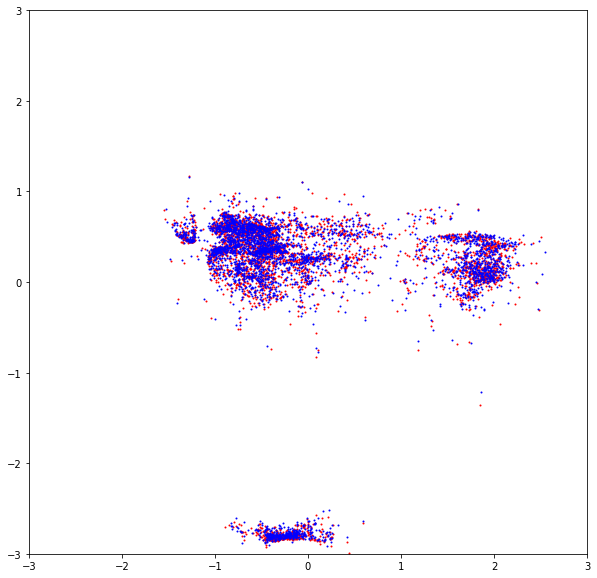

In [175]:
plt.figure(figsize=(10,10))
plt.scatter(zT_Allen[:,0],zT_Allen[:,1],c='r',s=1)
plt.scatter(M['zT'][:,0],M['zT'][:,1],c='b',s=1)
ax=plt.gca()
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
#Small differences here - not consequential to overall analysis. 

In [176]:
#Predict embedding:
zT_Tolias = model_TE.encoder_T(tf.constant(D['log1p'],dtype=tf.float32),training=False)
zT_Tolias = zT_Tolias.numpy()

In [177]:
#Predict Ephys data
XrE_Tolias = model_TE.decoder_E(tf.constant(zT_Tolias,dtype=tf.float32),training=False)

In [126]:
for n in anno_Tolias.columns.values:
    print(n)

T_sample_id
sample_id
E_sample_id
cluster
confidence
ADP (mV)
AHP (mV)
AI
AP amplitude (mV)
AP threshold (mV)
AP width (ms)
Max number of spikes
Input R (MOhm)
Vm (mV)
Latency (ms)
Rheobase (pA)
Sag ratio
Tau (ms)
Cell type
celltype
cluster_color


In [127]:
[n for n in O['E_names'] if 'spc' not in n]

['short sq. AP1 thr. v',
 'short sq. AP1 peak v',
 'short sq. AP1 upstroke',
 'short sq. AP1 downstroke',
 'short sq. AP1 up-down ratio',
 'short sq. AP1 width',
 'short sq. AP1 fast trough v',
 'short sq. current',
 'input resistance',
 'tau',
 'v baseline',
 'sag nearest minus 100',
 'sag measured at',
 'rheobase i',
 'long sq. AP1 threshold v',
 'long sq. AP1 peak v',
 'long sq. AP1 upstroke',
 'long sq. AP1 downstroke',
 'long sq. AP1 up-down ratio',
 'long sq. AP1 width',
 'long sq. AP1 fast trough v',
 'long sq. avg. rate',
 'long sq. latency',
 'long sq. stim. amp.']

In [178]:
anno_Tolias['cluster_color'].fillna('#000000',inplace=True)

In [179]:
names = [('rheobase i','Rheobase (pA)'), \
          ('tau','Tau (ms)'), \
          ('sag nearest minus 100','Sag ratio'), \
          ('v baseline','Vm (mV)'), \
          ('input resistance','Input R (MOhm)'), \
          ('long sq. AP1 width','AP width (ms)'), \
          ('short sq. AP1 width','AP width (ms)'),
          ('short sq. AP1 thr. v','AP threshold (mV)'),
          ('long sq. AP1 threshold v','AP threshold (mV)'),
          ('long sq. latency','Latency (ms)'),
          ('long sq. avg. rate','Max number of spikes')]

rheobase i


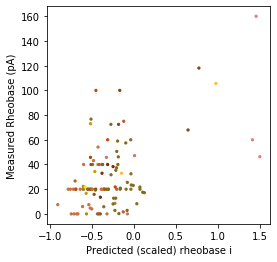

tau


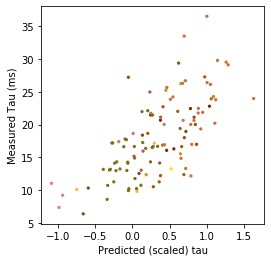

sag nearest minus 100


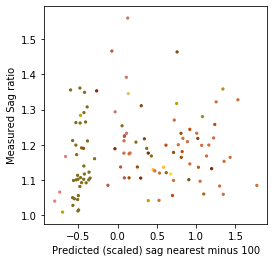

v baseline


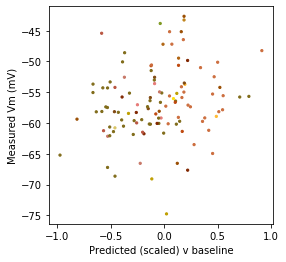

input resistance


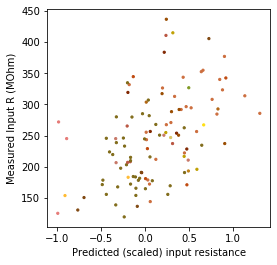

long sq. AP1 width


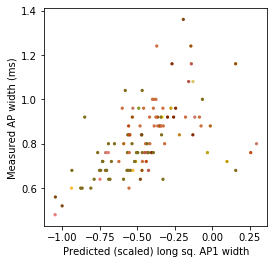

short sq. AP1 width


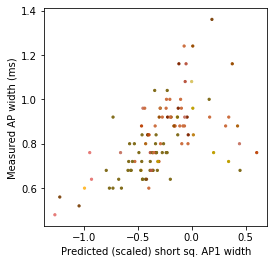

short sq. AP1 thr. v


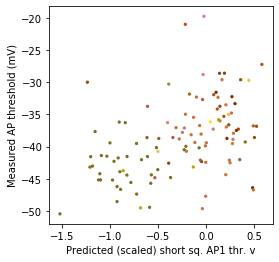

long sq. AP1 threshold v


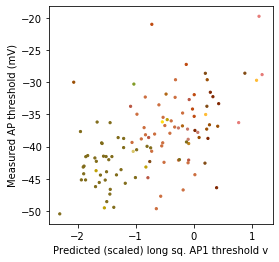

long sq. latency


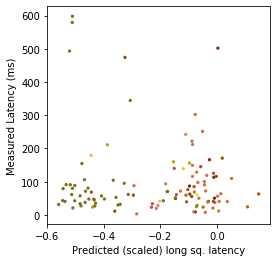

long sq. avg. rate


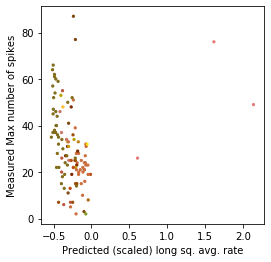

In [180]:
for x,y in names:
    print(x)
    ind = np.flatnonzero(O['E_names']==x)[0]
    plt.figure(figsize=(4,4))
    plt.scatter(XrE_Tolias[:,ind],anno_Tolias[y].values,c=anno_Tolias['cluster_color'].values,s=5)
    ax = plt.gca()
    ax.set_xlabel('Predicted (scaled) '+x)
    ax.set_ylabel('Measured '+y)
    #plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/'+y+'.png',dpi=300)
    plt.show()


In [181]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# neigh = KNeighborsClassifier(n_neighbors=8)
# neigh.fit(zT_Allen, O['cluster'])
# pred_lbl = neigh.predict(zT_Tolias)

remove=[]
for i in np.unique(O['cluster']):
    if np.sum(O['cluster']==i)<10:
        remove.append(np.flatnonzero(O['cluster']==i))

remove = np.concatenate(remove)
train_lbl = O['cluster'].copy()
z_train = zT_Allen.copy()
train_lbl = np.delete(train_lbl,remove,axis=0)
z_train = np.delete(z_train,remove,axis=0)
qda = QDA(reg_param=1e-2,store_covariance=True)
qda.fit(z_train, train_lbl)
pred_lbl = qda.predict(zT_Tolias)

true_lbl = anno_Tolias['cluster'].fillna('Unknown').values

In [182]:
pred_lbl[pred_lbl=='Sst Crh 4930553C11Rik ']='Sst Crh 4930553C11Rik'

In [183]:
from sklearn.metrics import confusion_matrix

all_labels = np.unique(np.concatenate([true_lbl,pred_lbl]))
type_list = sorted(list(set(zip(O['cluster_id'],O['cluster']))), key=lambda x: x[0])
type_list = [i for i in type_list if i[1] in all_labels]
all_labels = [i[1] for i in type_list]

keep_ind = np.isin(true_lbl,all_labels)
true_lbl = true_lbl[keep_ind]
pred_lbl = pred_lbl[keep_ind]
C = confusion_matrix(true_lbl,pred_lbl,labels=all_labels)

In [184]:
print('Number of cells assigned GABAergic classes in the dataset')
true_lbl.shape

Number of cells assigned GABAergic classes in the dataset


(107,)

In [185]:
print('Number of True positives, based on KNN classifier trained on co-ordinated representation')
np.sum(np.diag(C))

Number of True positives, based on KNN classifier trained on co-ordinated representation


75

In [186]:
np.sum(np.diag(C))/true_lbl.shape*100

array([70.09345794])

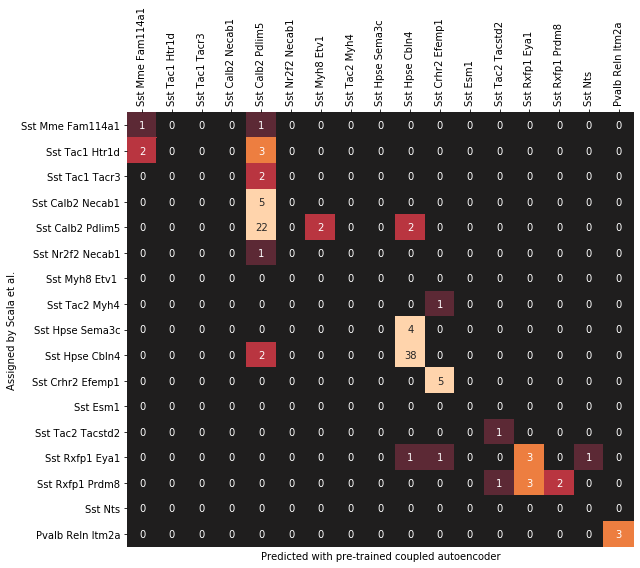

In [187]:
plt.figure(figsize=(9,8))
sns.heatmap(C,annot=True,vmin=0,vmax=4,center=0,cbar=False)
ax = plt.gca()
ax.set_yticks(np.arange(0,C.shape[0])+0.5)
ax.set_yticklabels(all_labels,rotation=0)
ax.set_ylabel('Assigned by Scala et al.')

ax.set_xticks(np.arange(C.shape[1])+0.5)
ax.set_xticklabels(all_labels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('Predicted with pre-trained coupled autoencoder')
plt.tight_layout()
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/Tolias_Type_pred.png',dpi=300)

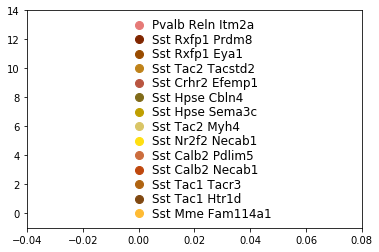

In [248]:
j=0
for i in all_labels:
    col = np.unique(anno_Tolias['cluster_color'][anno_Tolias['cluster']==i].values)
    if np.size(col)>0:
        plt.plot(0,j,'o',markersize=8,c=col[0])
        plt.text(0.005,j,i,{'verticalalignment':'center','fontsize':12})
        j=j+1
ax = plt.gca()
ax.set_xlim(-0.04,0.08)
ax.set_ylim(-1,14)
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/Tolias_Type_colors.png',dpi=300)
plt.show()


rheobase i


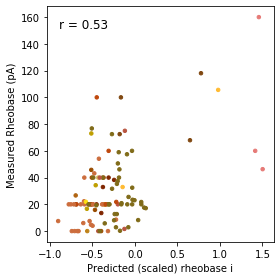

tau


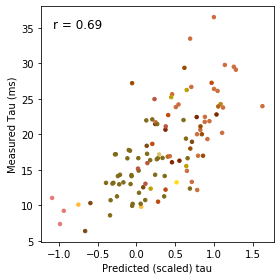

sag nearest minus 100


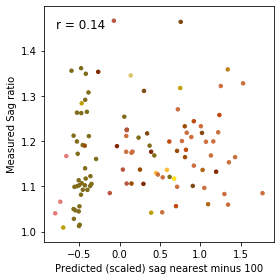

v baseline


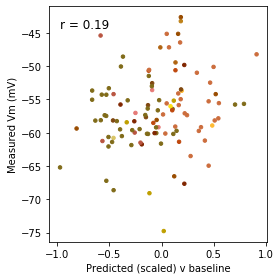

input resistance


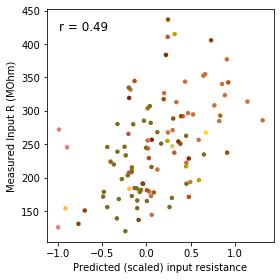

long sq. AP1 width


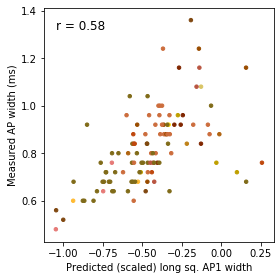

short sq. AP1 width


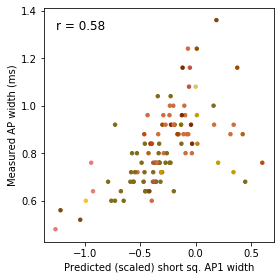

short sq. AP1 thr. v


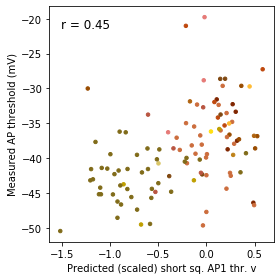

long sq. AP1 threshold v


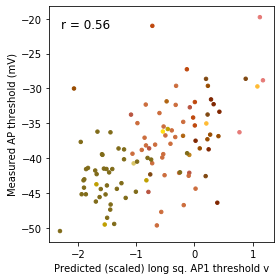

long sq. latency


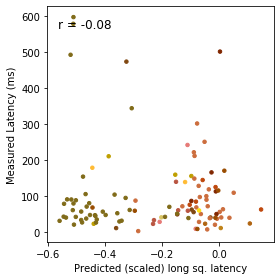

long sq. avg. rate


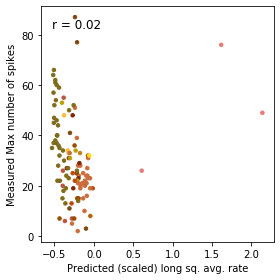

In [194]:
for x,y in names:
    print(x)
    ind = np.flatnonzero(O['E_names']==x)[0]
    plt.figure(figsize=(4,4))
    xdat = XrE_Tolias[:,ind][keep_ind].numpy()
    ydat = anno_Tolias[y].values[keep_ind]
    corrc = np.corrcoef(xdat,ydat)[1]
    plt.scatter(xdat,ydat,c=anno_Tolias['cluster_color'].values[keep_ind],s=12)
    ax = plt.gca()
    ax.set_xlabel('Predicted (scaled) '+x)
    ax.set_ylabel('Measured '+y)
    s = 'r = {:0.2f}'.format(corrc[0])
    ax.text(0.05, 0.95, s,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=12)
    plt.tight_layout()
    plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/'+y+'.png',dpi=300)
    plt.show()


Estimated coefficients (true, linear regression, RANSAC):
42.38550485581797 [-44.051933]


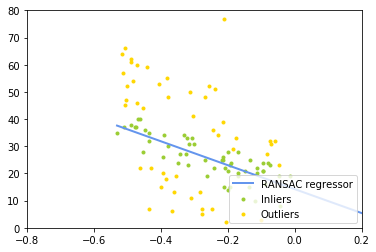

In [251]:

from sklearn import linear_model, datasets

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(np.expand_dims(xdat,-1), ydat)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(xdat.min(), xdat.max())[:, np.newaxis]
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, ransac.estimator_.coef_)

lw = 2
plt.scatter(xdat[inlier_mask], ydat[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(xdat[outlier_mask], ydat[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
ax=plt.gca()
ax.set_xlim(-0.8,0.2)
ax.set_ylim(-0,80)
plt.show()